In [2]:
import numpy as np
import pandas as pd
import json
import joblib


In [3]:

from dataclasses import dataclass
from typing import List, Tuple

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader, random_split

# >>> ADD
import os, json
from pathlib import Path
from datetime import datetime

class MLP(nn.Module):
    def __init__(
        self,
        in_features: int,
        hidden_layers: Tuple[int, ...],
        activation: str = "relu",
        dropout: float = 0.0,
        use_batchnorm: bool = False,
    ):
        super().__init__()
        acts = {
            "relu": nn.ReLU,
            "gelu": nn.GELU,
            "silu": nn.SiLU,
            "tanh": nn.Tanh,
        }
        if activation not in acts:
            raise ValueError(f"Unsupported activation: {activation}")

        layers: List[nn.Module] = []
        last = in_features
        for h in hidden_layers:
            layers.append(nn.Linear(last, h))
            if use_batchnorm:
                layers.append(nn.BatchNorm1d(h))
            layers.append(acts[activation]())
            if dropout > 0:
                layers.append(nn.Dropout(dropout))
            last = h

        self.backbone = nn.Sequential(*layers) if layers else nn.Identity()
        self.out = nn.Linear(last, 1)

        # Kaiming init for ReLU-like, Xavier otherwise
        for m in self.modules():
            if isinstance(m, nn.Linear):
                if activation in ("relu", "silu"):
                    nn.init.kaiming_normal_(m.weight, nonlinearity="relu")
                else:
                    nn.init.xavier_normal_(m.weight)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)

    def forward(self, x):
        z = self.backbone(x)
        logits = self.out(z)  # [B, 1]
        return logits

In [4]:
required_cols = ['temperature', 'heartrate', 'resprate', 'o2sat', 'sbp', 'dbp', 'pain', 'rhythm_flag', 'is_white', 'is_black', 'is_asian', 'is_hispanic', 'is_other_race', 'gender_F', 'gender_M', 'arrival_transport_AMBULANCE', 'arrival_transport_HELICOPTER', 'arrival_transport_OTHER', 'arrival_transport_UNKNOWN', 'arrival_transport_WALK IN', 'lactate', 'wbc', 'time_since_adm', 'gsn_16599.0', 'gsn_43952.0', 'gsn_4490.0', 'gsn_66419.0', 'gsn_61716.0']
your_input_dim = len(required_cols)
print(f"Input dimension: {your_input_dim}")

Input dimension: 28


In [5]:
with open("../grid_runs/top5_results.json", "r") as f:
    top5 = json.load(f)

best_cfg = top5[0]["config"]

mlp_model = MLP(
    in_features=your_input_dim,
    hidden_layers=tuple(best_cfg["layers"]),
    activation=best_cfg["activation"],
    dropout=best_cfg["dropout"],
    use_batchnorm=best_cfg["batchnorm"]
)

state_dict = torch.load("../grid_runs/best_model.pt", map_location="cpu")
mlp_model.load_state_dict(state_dict)
mlp_model.eval()

MLP(
  (backbone): Sequential(
    (0): Linear(in_features=28, out_features=128, bias=True)
    (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=128, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
  )
  (out): Linear(in_features=64, out_features=1, bias=True)
)

In [6]:
import xgboost as xgb
import numpy as np

# Load CPU model
xgbmodel = xgb.XGBClassifier(device='cpu')  # works for XGBoost ≥ 2.0
xgbmodel.load_model("../grid_runs_xgb/best_xgb.bin")


In [7]:
# model
model = joblib.load('../best_logistic_regression_model.joblib')
model

,steps,"[('scaler', ...), ('clf', ...)]"
,transform_input,None
,memory,None
,verbose,False
,copy,True
,with_mean,True
,with_std,True
,penalty,'elasticnet'
,dual,False
,tol,0.0001
,C,0.01


In [24]:
# read json
df = pd.read_csv('../data/MIMIC-ED/event_level_training_data.csv')
df.columns

Index(['stay_id', 'temperature', 'heartrate', 'resprate', 'o2sat', 'sbp',
       'dbp', 'pain', 'rhythm_flag', 'is_white', 'is_black', 'is_asian',
       'is_hispanic', 'is_other_race', 'gender_F', 'gender_M',
       'arrival_transport_AMBULANCE', 'arrival_transport_HELICOPTER',
       'arrival_transport_OTHER', 'arrival_transport_UNKNOWN',
       'arrival_transport_WALK IN', 'lactate', 'wbc', 'time_since_adm',
       'gsn_16599.0', 'gsn_43952.0', 'gsn_4490.0', 'gsn_66419.0',
       'gsn_61716.0', 'is_sepsis'],
      dtype='object')

In [25]:
# for each row, recalculate sepsis score
required_cols = ['temperature', 'heartrate', 'resprate', 'o2sat', 'sbp', 'dbp', 'pain', 'rhythm_flag', 'is_white', 'is_black', 'is_asian', 'is_hispanic', 'is_other_race', 'gender_F', 'gender_M', 'arrival_transport_AMBULANCE', 'arrival_transport_HELICOPTER', 'arrival_transport_OTHER', 'arrival_transport_UNKNOWN', 'arrival_transport_WALK IN', 'lactate', 'wbc', 'time_since_adm', 'gsn_16599.0', 'gsn_43952.0', 'gsn_4490.0', 'gsn_66419.0', 'gsn_61716.0']
X = df[required_cols]
true_labels = df["is_sepsis"].values

In [26]:
# infer with this X
sepsis_scores = model.predict_proba(X)[:, 1]
sepsis_scores = sepsis_scores.round(3) * 100
sepsis_scores

/Users/ykim/Desktop/septic6/sepsis/lib/python3.13/site-packages/sklearn/utils/validation.py:2742: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


array([ 6.4, 16.9, 32.3, ..., 88.9, 89.1, 65.3], shape=(96556,))

In [27]:
with torch.no_grad():
    X_test = torch.tensor(X.to_numpy(), dtype=torch.float32)
    logits = mlp_model(X_test)
    probs = torch.sigmoid(logits)

probs = probs.squeeze().numpy()
probs = probs.round(3) * 100
probs

array([ 0.2, 73.6, 75.2, ..., 86.7, 84.3, 77.4],
      shape=(96556,), dtype=float32)

In [28]:
xgb_probs = xgbmodel.predict_proba(X)[:, 1]
xgb_probs = xgb_probs.round(3) * 100
xgb_probs

array([ 0.      , 99.4     , 99.5     , ..., 65.100006, 58.499996,
       45.3     ], shape=(96556,), dtype=float32)

In [29]:
sepsis_scores = np.add(probs, xgb_probs) / 2
sepsis_scores = sepsis_scores.round(3)
sepsis_scores

array([ 0.1 , 86.5 , 87.35, ..., 75.9 , 71.4 , 61.35],
      shape=(96556,), dtype=float32)

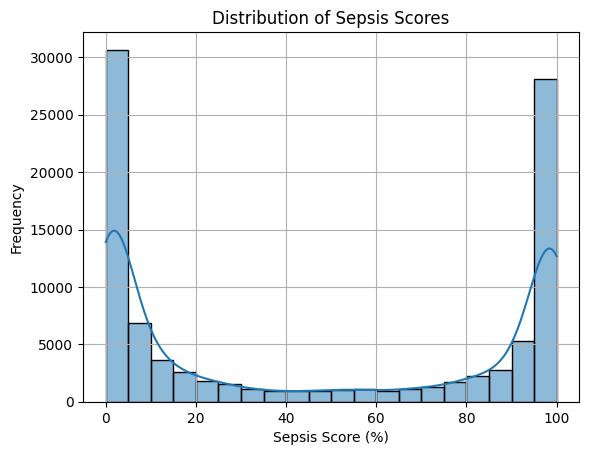

In [30]:
# explore quartiles for sepsis scores
import matplotlib.pyplot as plt
import seaborn as sns

sns.histplot(sepsis_scores, bins=20, kde=True)
plt.title("Distribution of Sepsis Scores")
plt.xlabel("Sepsis Score (%)")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

In [31]:
# what is the top 20th and 40th percentile?
percentiles = np.percentile(sepsis_scores, [80, 60])
print(f"20th percentile: {percentiles[0]:.2f}%")
print(f"40th percentile: {percentiles[1]:.2f}%")

20th percentile: 98.75%
40th percentile: 79.60%


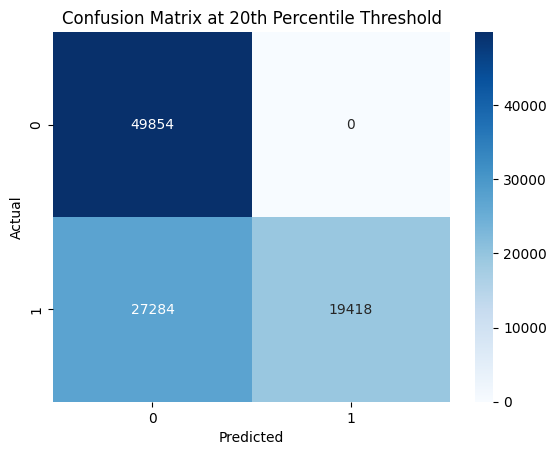

In [ ]:
# set threshold to top 20th percentile and create confusion matrix
threshold = percentiles[0]
preds = (sepsis_scores >= threshold).astype(int)
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(true_labels, preds)

# visualize confusion matrix
import matplotlib.pyplot as plt
import seaborn as sns
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix at 80th Percentile Threshold")
plt.show()

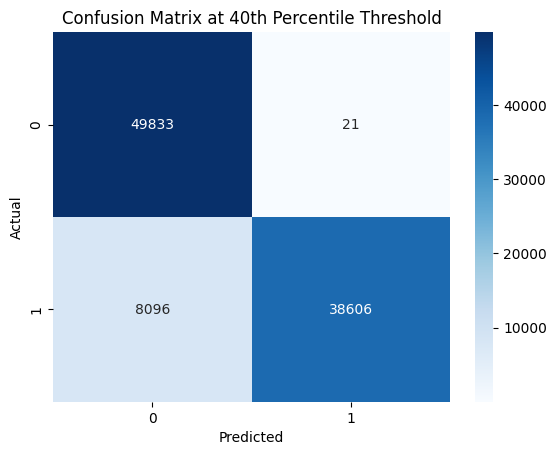

In [ ]:
# repeat for 40th percentile
threshold = percentiles[1]
preds = (sepsis_scores >= threshold).astype(int)
cm = confusion_matrix(true_labels, preds)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix at 60th Percentile Threshold")
plt.show()

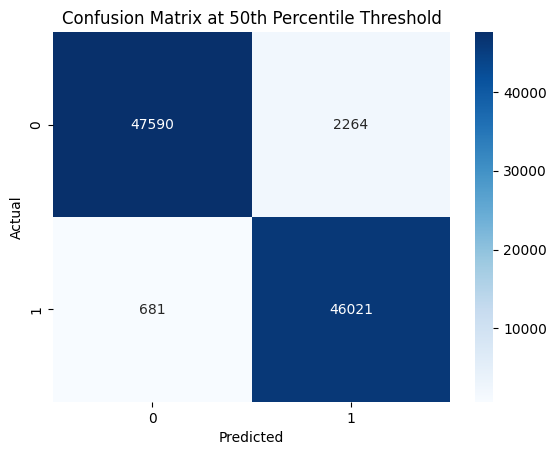

In [35]:
# try 50th percentile
threshold = np.percentile(sepsis_scores, 50)
preds = (sepsis_scores >= threshold).astype(int)
cm = confusion_matrix(true_labels, preds)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix at 50th Percentile Threshold")
plt.show()

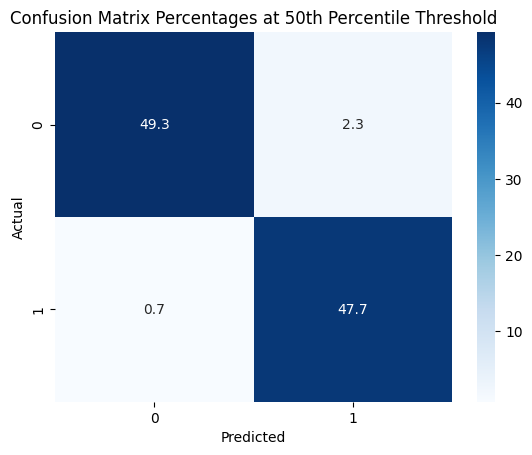

In [36]:
#change these to percentages
cm_percentages = cm / cm.sum() * 100
sns.heatmap(cm_percentages, annot=True, fmt=".1f", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")    
plt.title("Confusion Matrix Percentages at 50th Percentile Threshold")
plt.show()

Lowest threshold with no false positives: 69.00%
93.60%


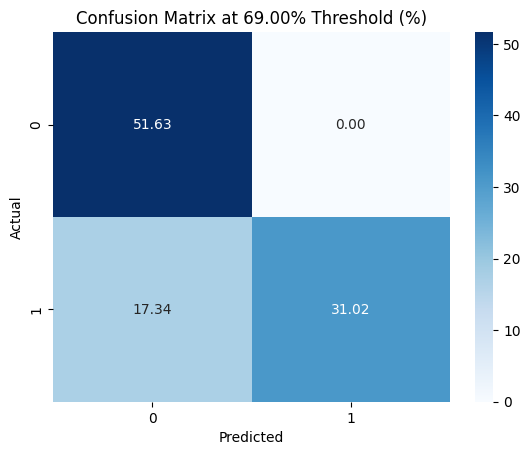

In [57]:
# find lowest theshold with no false positives
percentile = 100
cm = None
while True:
    cm_prev = cm
    prev_threshold = threshold
    threshold = np.percentile(sepsis_scores, percentile)
    preds = (sepsis_scores >= threshold).astype(int)
    cm = confusion_matrix(true_labels, preds)
    if cm[0, 1] == 0:  # no false positives
        percentile -= 0.1  # decrease threshold slightly
    if cm[0, 1] > 0:  # found the lowest threshold with no false positives
        print(f"Lowest threshold with no false positives: {percentile+0.1:.2f}%")
        print(f"{prev_threshold:.2f}%")

        # visualize confusion matrix in percentages
        cm_percentages = cm_prev / cm_prev.sum() * 100
        sns.heatmap(cm_percentages, annot=True, fmt=".2f", cmap="Blues")
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.title(f"Confusion Matrix at {percentile+0.1:.2f}% Threshold (%)")
        plt.show()
        break


50th percentile threshold: 35.60%


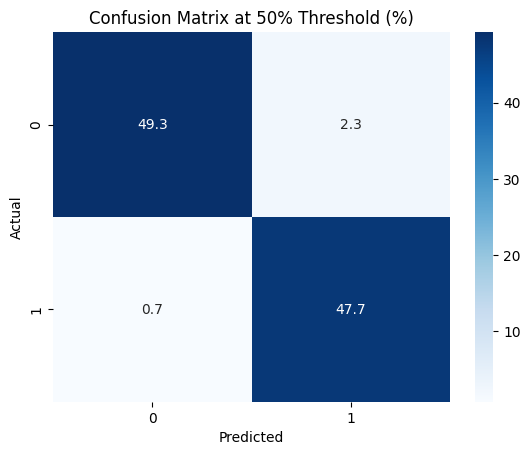

In [59]:
threshold_50 = np.percentile(sepsis_scores, 50)
print(f"50th percentile threshold: {threshold_50:.2f}%")

# visualize confusion matrix at 50th percentile in percentages
preds = (sepsis_scores >= threshold_50).astype(int)
cm = confusion_matrix(true_labels, preds)
cm_percentages = cm / cm.sum() * 100
sns.heatmap(cm_percentages, annot=True, fmt=".1f", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix at 50% Threshold (%)")
plt.show()  